# Problem: analyze the npm package graph

**npm** is a registry of Node.js packages which contains hundreds of thousands of software modules. Packages are frequently dependent on other packages. Thus, they define a **package graph**, where package names/versions are nodes, and the fact that package **a** depends on package **b** is represented by a directed edge from **a** to **b**.

Given a dump of the **npm** package database (we'll use a small subset for this exercise), transform it into a networkx graph and save it to a .pickle file. Then, load the file and compute graph metrics.

## Task 1 - Convert the JSON database dump into a networkx graph

In [1]:
# 1.1. Load the JSON file into a Python object.
import json

with open("example_db.json", 'r') as inF:
    print("Loading JSON file...")
    db = json.load(inF)
    print("Done!")

Loading JSON file...
Done!


In [2]:
# 1.2. Turn the Python object into a networkx graph

# 1.2.1. First, we need to do some data cleanup
# We define a function to identify package entries with missing
# or incomplete information, so we can exclude those
def check_package(package):
    if 'doc' not in package:
        return False
    if 'name' not in package['doc']:
        return False
    if 'versions' not in package['doc']:
        return False
    if not package['doc']['versions']:
        return False
    return True

In [4]:
# 1.2.2. Now we can create the graph
import networkx as nx
from natsort import natsorted

print("Creating dependency graph...")
packages = db['rows']
count = 0
G = nx.DiGraph()
for package in packages:
    if not check_package(package):
        continue
    name = package['doc']['name']
    versions = package['doc']['versions']
    latest = versions[natsorted([v for v in versions.keys()])[-1]]
    dependencies = [k for k in latest['dependencies'].keys()] if 'dependencies' in latest else []
    if dependencies:
        for dep in dependencies:
            G.add_edge(name, dep)
    count += 1
    if count and not count % 10000:
        print("Processed %d packages!")
print("Done creating dependency graph!")


Creating dependency graph...
Done creating dependency graph!


In [6]:
# 1.3. Save the database to a pickle file
import pickle

print("Pickling (yum yum...)")
with open("example_db.pickle", 'wb') as outF:
    pickle.dump(G, outF, pickle.HIGHEST_PROTOCOL)

Pickling (yum yum...)


## Task 2 - Analyzing the graph

In [18]:
# 3.1 - Load file back from pickle
print('Loading file...')
with open("example_db.pickle", 'rb') as inF:
    G = pickle.load(inF)
print('Done!...')

Loading file...
Done!...


In [19]:
# 3.2 - Basic statistics: number of nodes, number of edges
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())


Number of nodes: 310
Number of edges: 325


In [21]:
# 3.3 Number of indirect dependencies
from statistics import mean
print('Computing transitive closures... (# indirect dependencies)')
tc = {}
for n in G.nodes:
    tc[n] = len(nx.single_source_dijkstra_path_length(G,n )) - 1
tc_avg = mean(tc.values())
print('Done! Avg: %f' % tc_avg)

Computing transitive closures... (# indirect dependencies)
Done! Avg: 1.048387
Computing reverse transitive closures... (# indirect dependents)
Done! Avg: 1.048387


In [22]:
# 3.4 Number of direct dependencies

print('Computing outdegrees... (# direct dependencies)')
og = {}
for n in G.nodes:
    og[n] = G.out_degree(n)
og_avg = mean(og.values())

print('Done! Avg: %f' % og_avg)

Computing outdegrees... (# direct dependencies)
Done! Avg: 1.048387


In [23]:
# 3.5 Depth of dependency tree

print('Computing dep tree depths')
dd = {}
for n in G.nodes:
    dd[n] = max(nx.single_source_dijkstra_path_length(G, n).values())
dd_avg = mean(dd.values())
print('Done! Avg: %f' % dd_avg)


Computing dep tree depths
Done! Avg: 0.203226


In [24]:
# 3.6 Find connected components

print('Computing connected components...')
ccs_sizes =  [len(cc) for cc in nx.connected_components(G.to_undirected(as_view=True))]
ccs_len = len(ccs_sizes)
ccs_avg = mean(ccs_sizes)
print('Done! #CC: %d, Avg size: %f ' % (ccs_len, ccs_avg))

Computing connected components...
Done! #CC: 16, Avg size: 19.375000 


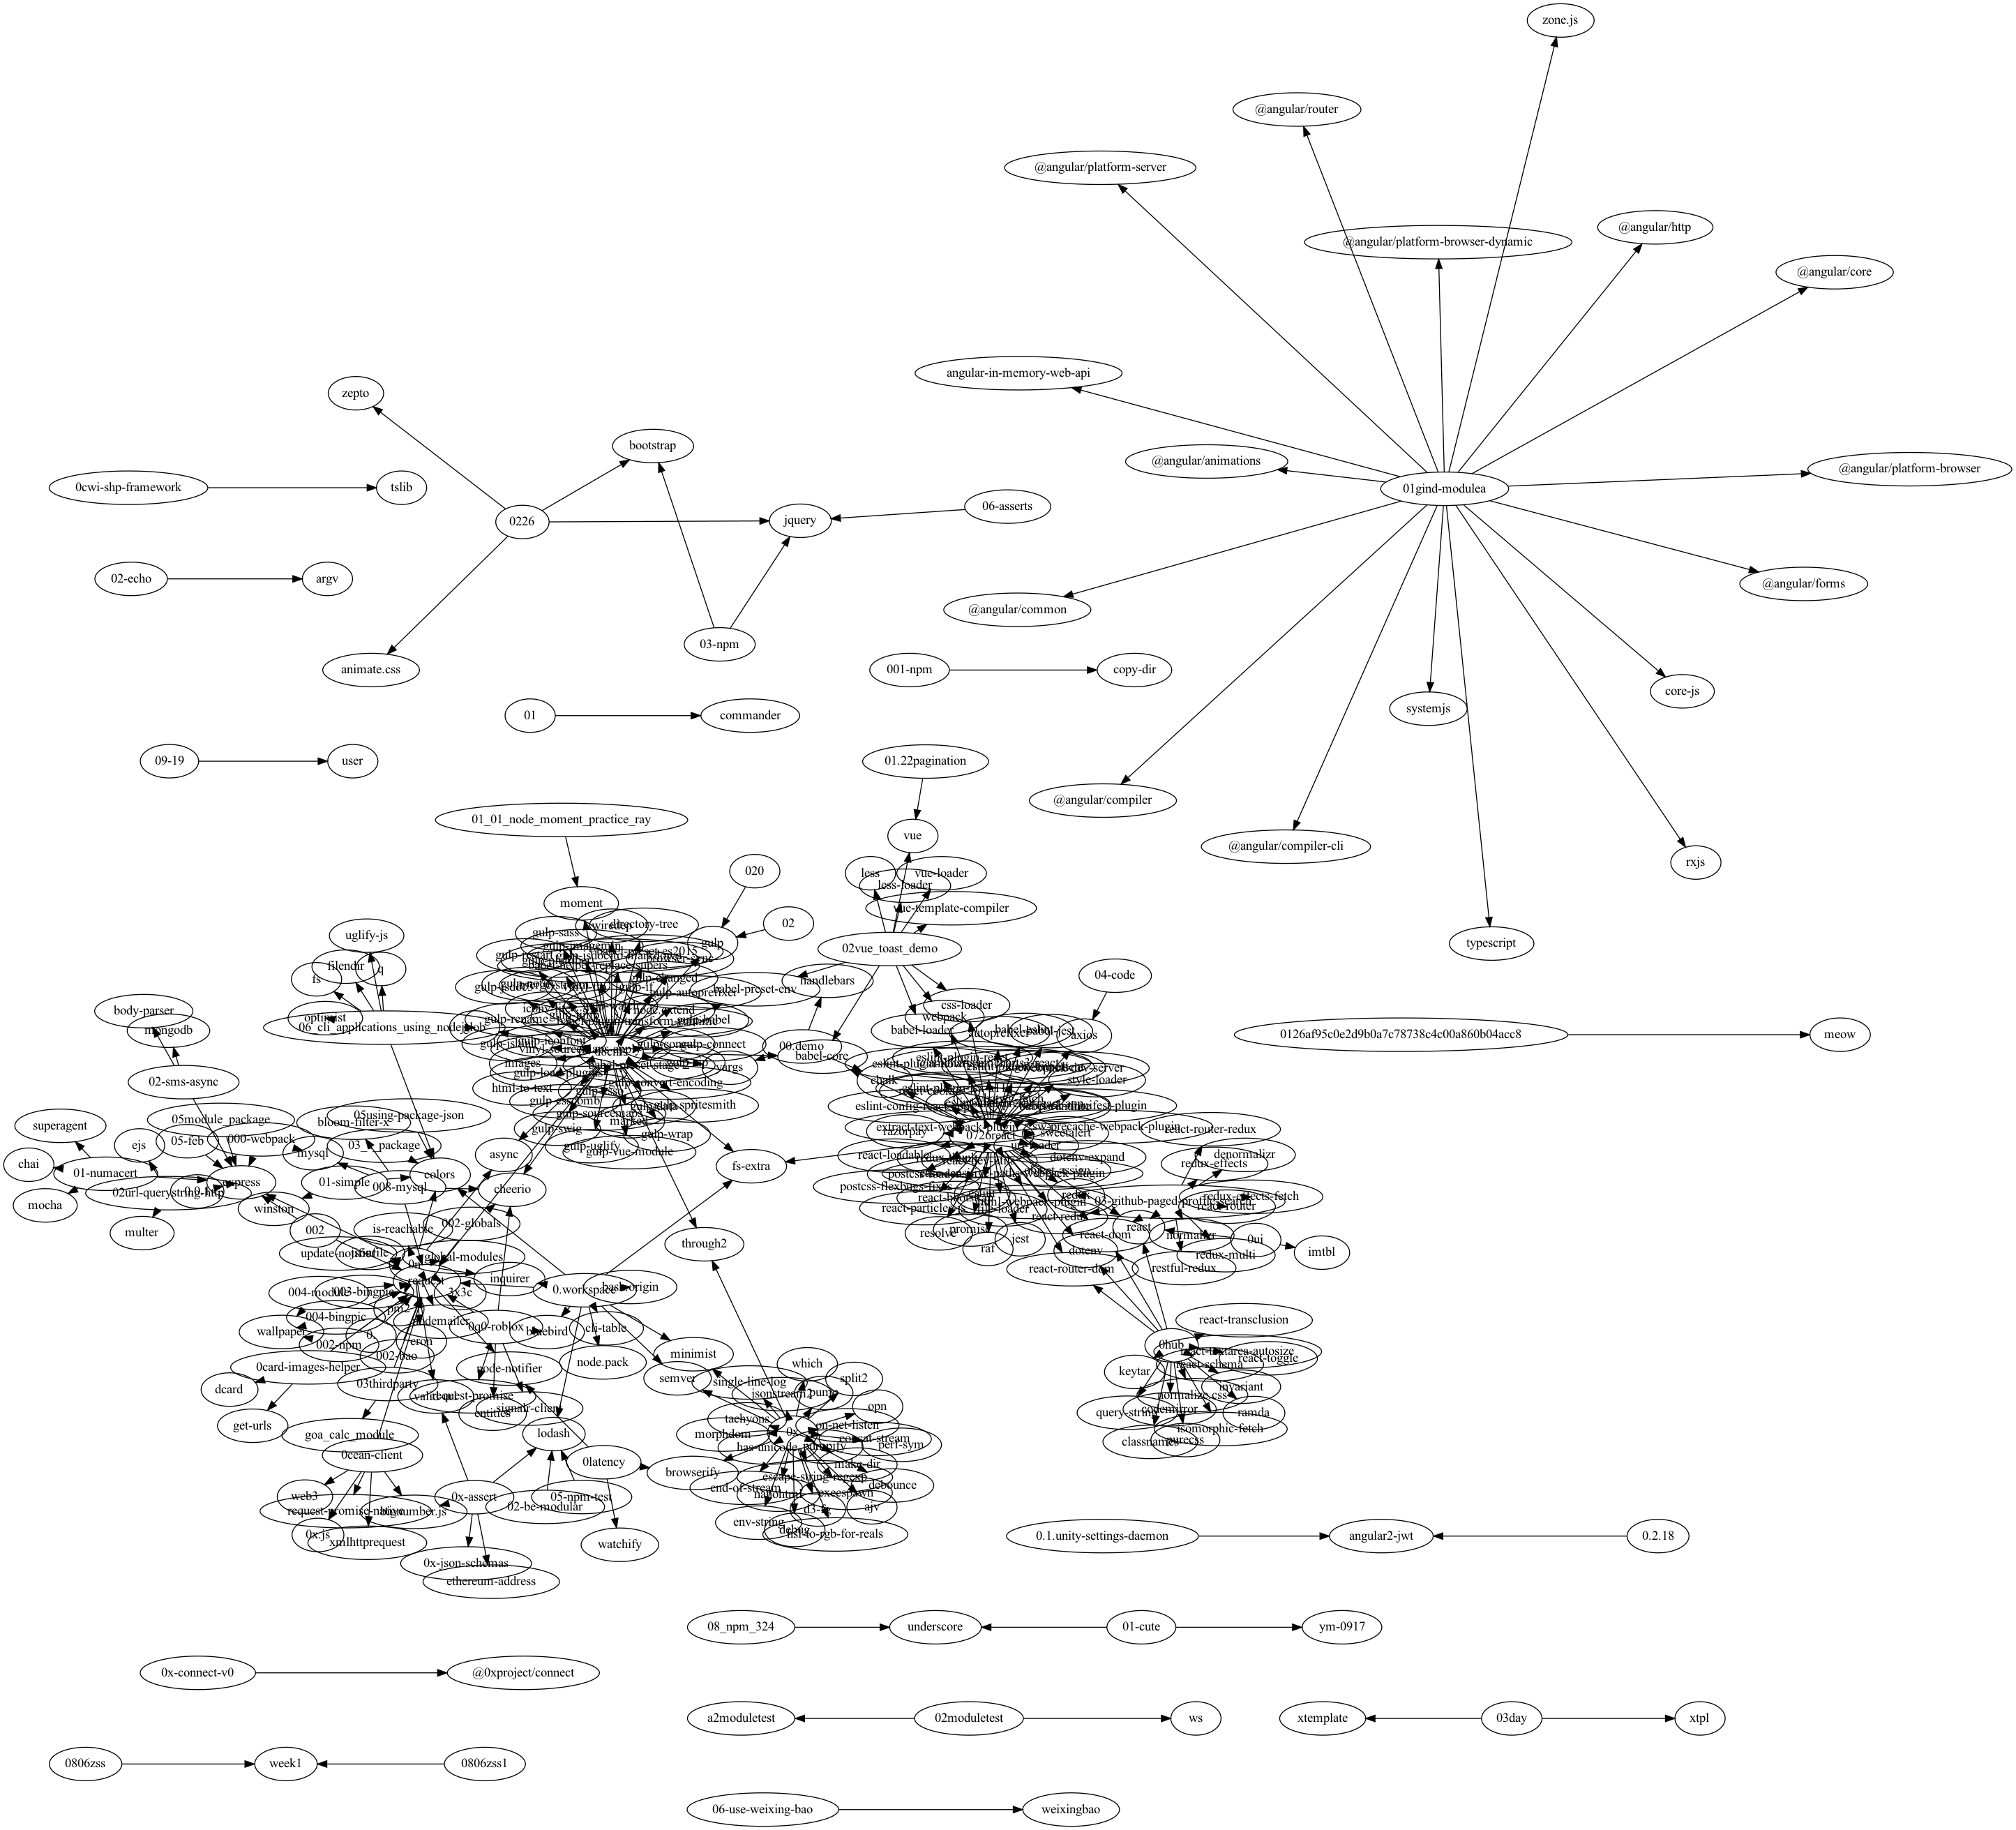

In [32]:
# 3.7 Can we even visualize this?
from IPython.display import Image, display

gg = nx.nx_agraph.to_agraph(G)
gg.draw('depgraph.png', prog='sfdp')
display(Image('depgraph.png', width=1200))